# Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Methodology

Now that we chose a clustering model, it is important to understand when personas are changing too. In this perpective, we have to update the clustering model on a period frequencies in order to evaluate is customers behaviour is changing and how to adress them if it is so.

In order to find the best period lapse to reevaluate our customer, we will use the past 2 years data and evaluate what are the frequencies of consumption behaviour chnages.

# Setting first tests data

In [81]:
df_orders = pd.read_pickle('../data/df_orders_details.pkl')
print(df_orders.info())
print(f"Last date of the dataset: {(df_orders['order_purchase_date'].max())}")

<class 'pandas.core.frame.DataFrame'>
Index: 116211 entries, 0 to 117917
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   customer_unique_id             116211 non-null  object  
 1   order_id                       116211 non-null  object  
 2   order_status                   116211 non-null  object  
 3   item_price                     116211 non-null  float64 
 4   freight_value                  116211 non-null  float64 
 5   payment_value                  116211 non-null  float64 
 6   payment_sequential             116211 non-null  int64   
 7   payment_type                   116211 non-null  object  
 8   payment_installments           116211 non-null  int64   
 9   review_score                   116211 non-null  int64   
 10  product_category_name_english  116211 non-null  object  
 11  order_processing_time          116211 non-null  float64 
 12  order_purchase_date  

## Evaluate the starting moment (We moved this step into the preparation of data step.)

Working on orders from 2017-01-05 00:00:00 to 2017-04-05 00:00:00 for 6612 orders.
<class 'pandas.core.frame.DataFrame'>
Index: 5273 entries, 0 to 5312
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_orders           5273 non-null   int64  
 1   total_expenses         5273 non-null   float64
 2   average_review_score   5273 non-null   float64
 3   days_since_last_order  5273 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 206.0 KB
None
Working on orders from 2017-01-05 00:00:00 to 2017-04-05 00:00:00 for 6612 orders.


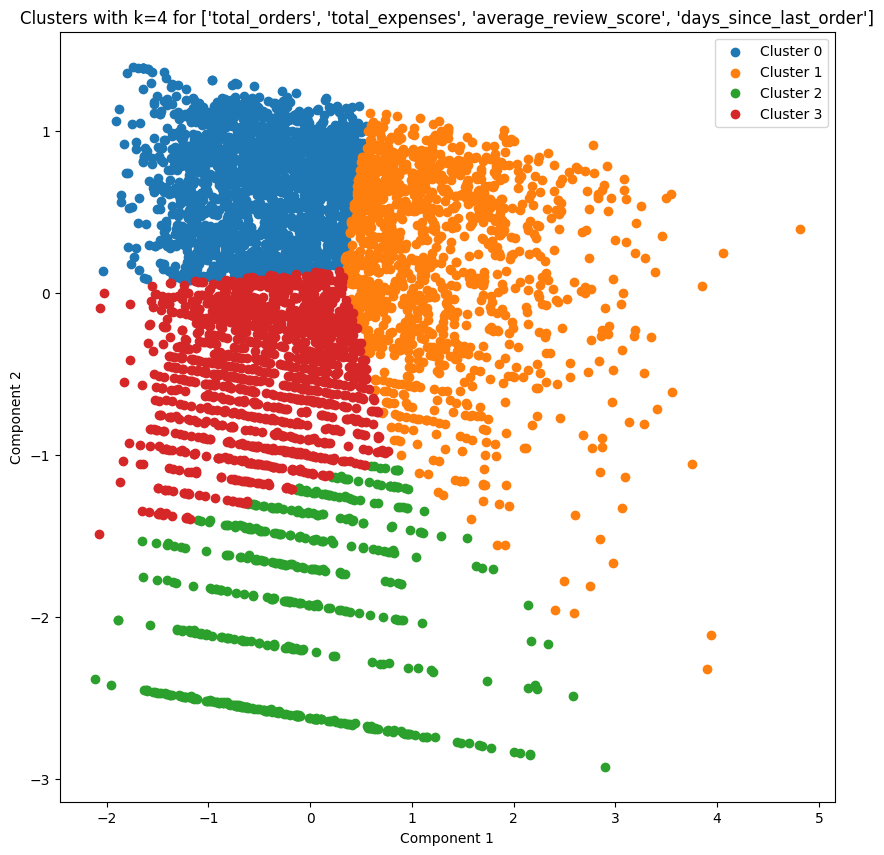

Appending ARI score 1.0 for period ending 2017-04-05 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-04-12 00:00:00 for 7229 orders.
Appending ARI score 0.3082782940243271 for period ending 2017-04-12 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-04-19 00:00:00 for 7742 orders.
Appending ARI score 0.3095071592933278 for period ending 2017-04-19 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-04-26 00:00:00 for 8576 orders.
Appending ARI score 0.7018146208843182 for period ending 2017-04-26 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-05-03 00:00:00 for 9339 orders.
Appending ARI score 0.36608544931465425 for period ending 2017-05-03 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-05-10 00:00:00 for 10286 orders.
Appending ARI score 0.38329297580704336 for period ending 2017-05-10 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-05-17 00:00:00 for 11337 orders.
Appending ARI score 0.375666683501343 for period en

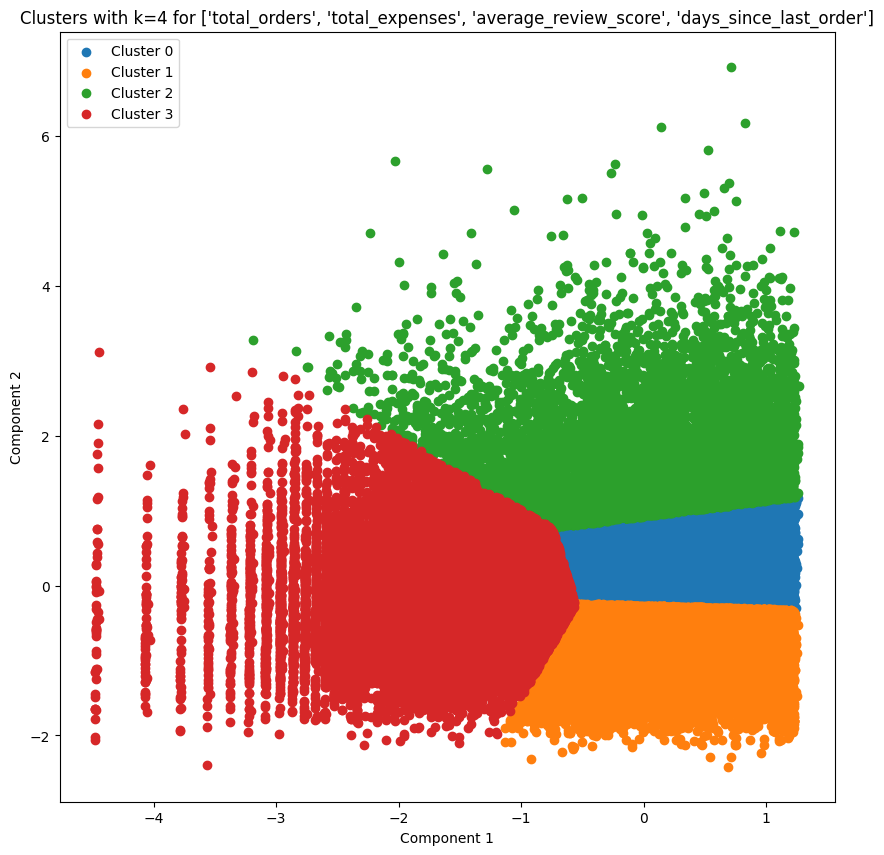

/var/folders/4f/ml64c07d1zsg_jvvydhyltjr0000gn/T/ipykernel_11092/2858917906.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


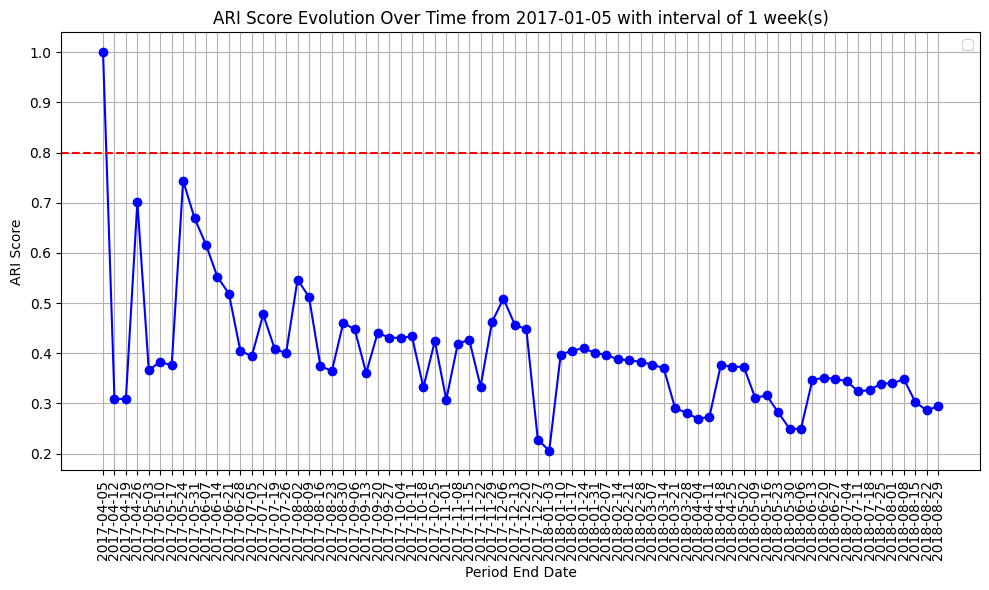

In [74]:
# Instanciate the first dataset
first_order_date = pd.to_datetime(df_orders["order_purchase_date"].min())
# last_date_of_orders = pd.to_datetime("2017-12-31")

# Set the variables
f = [3,1]  # frequency of the period : base period and current period
period = ["month", "week"]  # period to calculate the frequency (week or month)
k = 4 # number of clusters

plot_ari_evolution(first_order_date, f, k, period)

# Functions

## Aggregate

In [82]:
def aggregate_to_customer(
    df: pd.DataFrame,
    last: pd.Timestamp,
    start: pd.Timestamp,
    period: str,
    period_lapse: int,
) -> tuple:
    """ Build the customer dataframe according to periods

    Args:
        df (pd.DataFrame): the dataframe to aggregate (df_orders)
        last (pd.Timestamp): the date from which to calculate the recency
        start (pd.Timestamp): the date to start the aggregation
        period (str): the period to calculate the frequency ("week" or "month")
        period_laps (int): the number of weeks/months to calculate the frequency

    Returns:
        tuple: the customer dataframe, the one scaled with log and the last date of the dataset of the current dataset
    """
    df_copy = df.copy()
    # Change dates column to pd.datetime
    df_copy["order_purchase_date"] = pd.to_datetime(df_copy["order_purchase_date"])

    # Select the period in the dataframe
    if period == "week":
        mask = df_copy["order_purchase_date"] <= last + pd.DateOffset(weeks=period_lapse)
    elif period == "month":
        mask = df_copy["order_purchase_date"] <= last + pd.DateOffset(months=period_lapse)
    else:
        raise ValueError("The period should be either week or month")
    df_period = df_copy[(df_copy["order_purchase_date"] >= start) & mask]

    print(f"Working on orders from {start} to {df_period['order_purchase_date'].max()} for {df_period.shape[0]} orders.")

    last_date_of_orders = df_period["order_purchase_date"].max()

    # Update the customer aggregation
    df_sorted = df_period.sort_values(by=["customer_unique_id", "order_purchase_date"])
    df_grouped = df_sorted.groupby("customer_unique_id")

    df_customers = df_grouped.agg(
        first_order_date=("order_purchase_date", "min"),
        last_order_date=("order_purchase_date", "max"),
        total_orders=("order_id", "count"),
        total_expenses=("payment_value", "sum"),
        average_review_score=("review_score", "mean"),
        # usual_moment_of_order_str=("order_purchase_time_bin", lambda x: x.mode()[0]),
        # average_delivery_delays=("delivery_delay", "mean"),
        average_days_late=("days_late_count", "mean"),
        cancelled_orders=("canceled_orders", "sum"),
    )


    # Get the last date of the dataset
    last_date_of_orders = df_period["order_purchase_date"].max()

    df_customers = df_customers.reset_index()

    # Calculate the number of days since the last order
    df_customers["days_since_last_order"] = (last_date_of_orders - df_customers["last_order_date"]).dt.days
    # replace 0 days by 1 day to avoid having 0
    df_customers["days_since_last_order"] = df_customers["days_since_last_order"].apply(
        lambda x: 1 if x == 0 else x
    )
    # time_of_day_order = ["Night", "Morning", "Noon", "Afternoon", "Evening"]
    # df_customers["usual_moment_of_order_int"] = df_customers[
    #  "usual_moment_of_order_str"].apply(lambda x: time_of_day_order.index(x)).astype(int)

    # drop rows where total orders = total cancelled orders
    df_customers = df_customers[df_customers["total_orders"] != df_customers["cancelled_orders"]]

    # columns to drop to get back to our final cluster dataframe
    columns_to_drop = [
        "customer_unique_id",
        "first_order_date",
        "last_order_date",
        # "usual_moment_of_order_str",
        "cancelled_orders",
    ]

    df_customers = df_customers.drop(columns=columns_to_drop)

    df_customers_log = df_customers.copy()
    df_customers_log = np.log1p(df_customers)


    return df_customers, df_customers_log, last_date_of_orders

## Visualize

In [10]:
def plot_two_dim_clusters(df: pd.DataFrame, scaled_df: pd.DataFrame, k: int):
    """Plots clusters after reducing the data to 2 dimensions using PCA

    Args:
        df (pd.DataFrame): original dataframe
        scaled_df (pd.DataFrame): dataframe with scaled features used for clustering
        k (int): number of clusters to try
    """
    pca = PCA(n_components=2)
    reduced_df = pca.fit_transform(scaled_df)
    features_names = df.columns.tolist()

    model = KMeans(k, random_state=42, max_iter=300)
    labels = model.fit_predict(reduced_df)

    # Add cluster to the original dataframe
    df["cluster"] = labels

    # Plot clusters
    u_labels = np.unique(labels)
    plt.figure(figsize=(10, 10))
    for i in u_labels:
        plt.scatter(
            reduced_df[labels == i, 0],
            reduced_df[labels == i, 1],
            label=f"Cluster {i}",
        )
    # take cluster out of the features list
    plt.legend()
    plt.title(f"Clusters with k={k} for {features_names}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


## Evaluation

In [73]:
def plot_ari_evolution(first_order_date: pd.Timestamp, f: list[int], k: int, period : list[str], df_base: pd.DataFrame = df_orders):
    """Plot the ARI score evolution over time

    Args:
        first_order_date (pd.Timestamp): starting date of the dataset
        f (list[int]): frequency of the data aggregation. First element is the number of weeks or months for the base dataset, second element is the number of weeks or months for the current dataset, then for the interval to calculate the ARI score
        k (int): Number of clusters to try
        period (list[str]): "week" or "month". First element is the period for the base dataset, second element is the period for the current dataset
        df_base (pd.DataFrame, optional): DataFrame to use for aggregation. Defaults to df_orders.
    """

    i = 0 # iteration
    # Get first data
    original_customers, customers_reference_log, last_date_of_orders = aggregate_to_customer(
        df_base, first_order_date, first_order_date, period[0], f[0]
    )

    print(original_customers.info())
    # Store ARI score in a list
    ari_scores = []

    # Fit the KMeans model on the first week of data
    kmeans_ref = KMeans(n_clusters=k, random_state=42, max_iter=300)
    kmeans_ref.fit(customers_reference_log)

    while last_date_of_orders < pd.to_datetime("2018-08-29"):
        if i == 0:
            current_customers, customers_current_log, last_date_of_orders = (
                aggregate_to_customer(
                    df_base, first_order_date, first_order_date, period[0], f[0]
                )
            )
            # Plot the first week of data
            plot_two_dim_clusters(
                current_customers,
                customers_current_log,
                k,
            )
        else:
            # Update data with current period
            current_customers, customers_current_log, last_date_of_orders = (
                aggregate_to_customer(
                    df_base, last_date_of_orders, first_order_date, period[1], f[1]
                )
            )

        i += 1
        # predict initial model
        reference_labels = kmeans_ref.predict(customers_current_log)

        # refit the model
        kmeans_current = KMeans(n_clusters=k, random_state=42, max_iter=300)
        current_labels = kmeans_current.fit_predict(customers_current_log)


        # Calculate ARI score between current and previous period
        ari = adjusted_rand_score(reference_labels, current_labels)

        print(f"Appending ARI score {ari} for period ending {last_date_of_orders}")
        ari_scores.append((last_date_of_orders, ari))


    print(f"Current dataset is from {first_order_date} to {last_date_of_orders}")
    plot_two_dim_clusters(
        current_customers,
        customers_current_log,
        k,
    )


    # Plot the ARI score evolution
    periods = [period_end for period_end, _ in ari_scores]
    ari_values = [ari for _, ari in ari_scores]

    plt.figure(figsize=(10, 6))
    plt.plot(periods, ari_values, marker="o", linestyle="-", color="b")
    plt.legend()
    plt.axhline(y=0.8, color="r", linestyle="--")
    plt.xlabel("Period End Date")
    plt.ylabel("ARI Score")
    plt.title(f"ARI Score Evolution Over Time from {first_order_date.date()} with interval of {f[1]} {period[1]}(s)")
    plt.xticks(periods, rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [91]:
def compare(first_order_date: pd.Timestamp, f: list[int], k: int, period: list[str]):
    """Compare the ARI score evolution between two models

    """
    i=0
    ari_scores = []
    # First model is 3 months of data
    original_customers, customers_reference_log, last_date_of_orders = aggregate_to_customer(
        df_orders, first_order_date, first_order_date, period[0], f[0]
    )
    # fit reference model
    kmeans_ref = KMeans(n_clusters=k, random_state=42, max_iter=300)
    kmeans_ref.fit(customers_reference_log)

    while last_date_of_orders < pd.to_datetime("2018-08-29"):
        # If i is a multiple of 4
        if i % 4 == 0 and i != 0:
            original_customers, customers_reference_log, last_date_of_orders = (
                aggregate_to_customer(
                    df_orders, last_date_of_orders, first_order_date, period[1], f[1]
                )
            )
            # fit the model
            kmeans_ref = KMeans(n_clusters=k, random_state=42, max_iter=300)
            kmeans_ref.fit(customers_reference_log)

        if i == 0:
            current_customers, customers_current_log, last_date_of_orders = aggregate_to_customer(
                df_orders, last_date_of_orders, first_order_date, period[1], f[1]
            )
        else:
            # current period
            current_customers, customers_current_log, last_date_of_orders = aggregate_to_customer(
                df_orders, last_date_of_orders, first_order_date, period[1], f[1]
            )
        i += 1
        # predict initial model
        reference_labels = kmeans_ref.predict(customers_current_log)

        # refit the model
        kmeans_current = KMeans(n_clusters=k, random_state=42, max_iter=300)
        current_labels = kmeans_current.fit_predict(customers_current_log)

        # Calculate ARI score between current and previous period
        ari = adjusted_rand_score(reference_labels, current_labels)

        print(f"Appending ARI score {ari} for period ending {last_date_of_orders}")
        ari_scores.append((last_date_of_orders, ari))

    print(f"Current dataset is from {first_order_date} to {last_date_of_orders}")
    plot_two_dim_clusters(
        current_customers,
        customers_current_log,
        k,
    )

    # Plot the ARI score evolution
    periods = [period_end for period_end, _ in ari_scores]
    ari_values = [ari for _, ari in ari_scores]

    plt.figure(figsize=(10, 6))
    plt.plot(periods, ari_values, marker="o", linestyle="-", color="b")
    plt.legend()
    plt.axhline(y=0.8, color="r", linestyle="--")
    plt.xlabel("Period End Date")
    plt.ylabel("ARI Score")
    plt.title(
        f"ARI Score Evolution Over Time from {first_order_date.date()} with interval of {f[1]} {period[1]}(s)"
    )
    plt.xticks(periods, rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ARI scores

Working on orders from 2017-01-05 00:00:00 to 2017-04-05 00:00:00 for 6612 orders.
<class 'pandas.core.frame.DataFrame'>
Index: 5273 entries, 0 to 5312
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_orders           5273 non-null   int64  
 1   total_expenses         5273 non-null   float64
 2   average_review_score   5273 non-null   float64
 3   average_days_late      5273 non-null   float64
 4   days_since_last_order  5273 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 247.2 KB
None
Working on orders from 2017-01-05 00:00:00 to 2017-04-05 00:00:00 for 6612 orders.


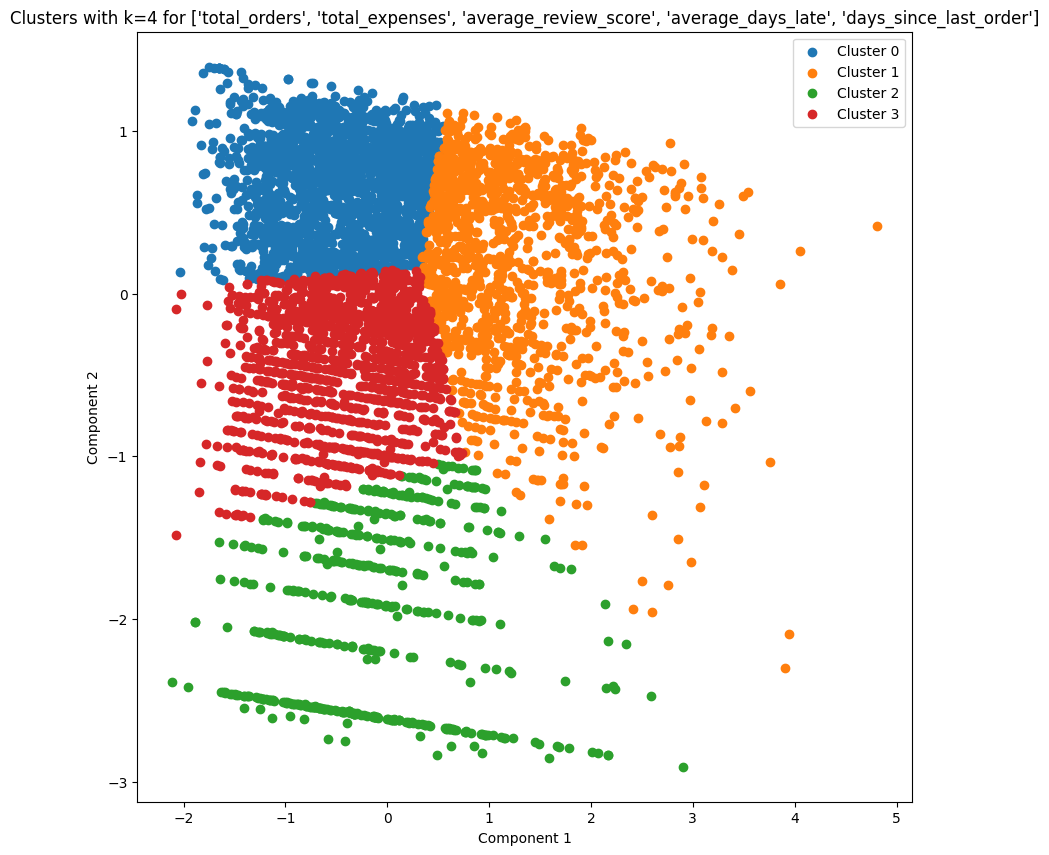

Appending ARI score 1.0 for period ending 2017-04-05 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-04-12 00:00:00 for 7229 orders.
Appending ARI score 0.41174163113016365 for period ending 2017-04-12 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-04-19 00:00:00 for 7742 orders.
Appending ARI score 0.2702981000502518 for period ending 2017-04-19 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-04-26 00:00:00 for 8576 orders.
Appending ARI score 0.8917342636732125 for period ending 2017-04-26 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-05-03 00:00:00 for 9339 orders.
Appending ARI score 0.3955698789588096 for period ending 2017-05-03 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-05-10 00:00:00 for 10286 orders.
Appending ARI score 0.3721801787054556 for period ending 2017-05-10 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-05-17 00:00:00 for 11337 orders.
Appending ARI score 0.36872030841210274 for period e

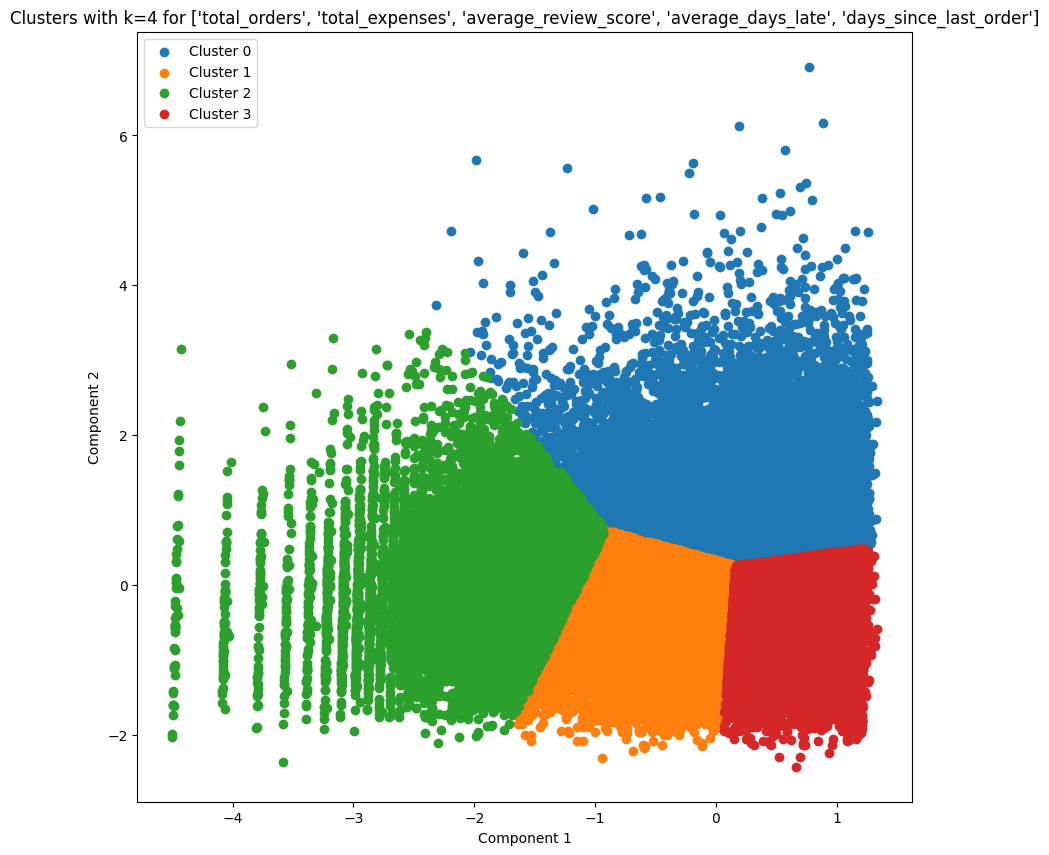

/var/folders/4f/ml64c07d1zsg_jvvydhyltjr0000gn/T/ipykernel_11092/2858917906.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


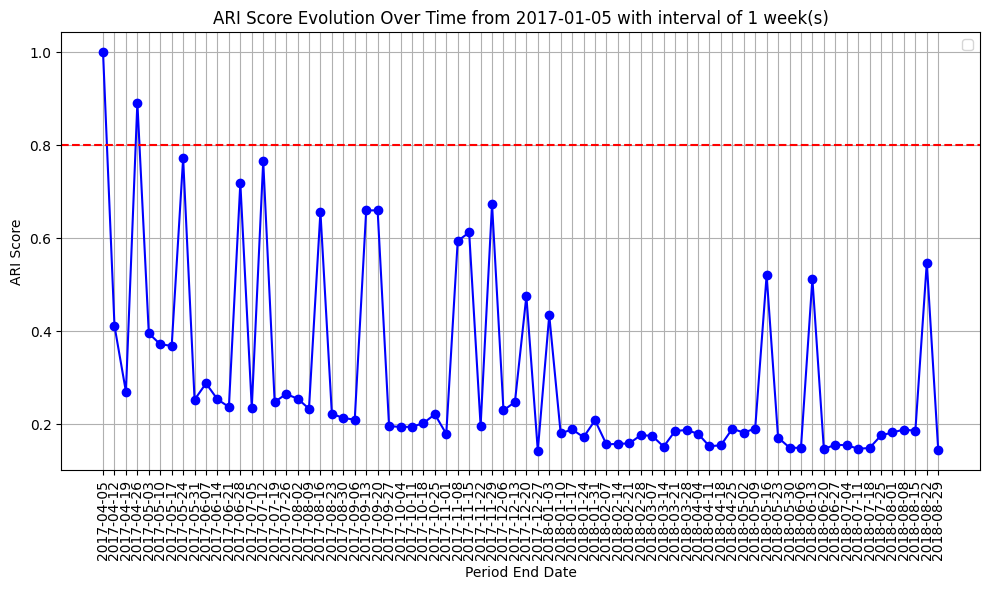

In [85]:
first_order_date = pd.to_datetime(df_orders["order_purchase_date"].min())
period = ["month", "week"]
f = [3, 1]
plot_ari_evolution(first_order_date, f, k, period)

Working on orders from 2017-01-05 00:00:00 to 2017-04-05 00:00:00 for 6612 orders.
<class 'pandas.core.frame.DataFrame'>
Index: 5273 entries, 0 to 5312
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_orders           5273 non-null   int64  
 1   total_expenses         5273 non-null   float64
 2   average_review_score   5273 non-null   float64
 3   average_days_late      5273 non-null   float64
 4   days_since_last_order  5273 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 247.2 KB
None
Working on orders from 2017-01-05 00:00:00 to 2017-04-05 00:00:00 for 6612 orders.


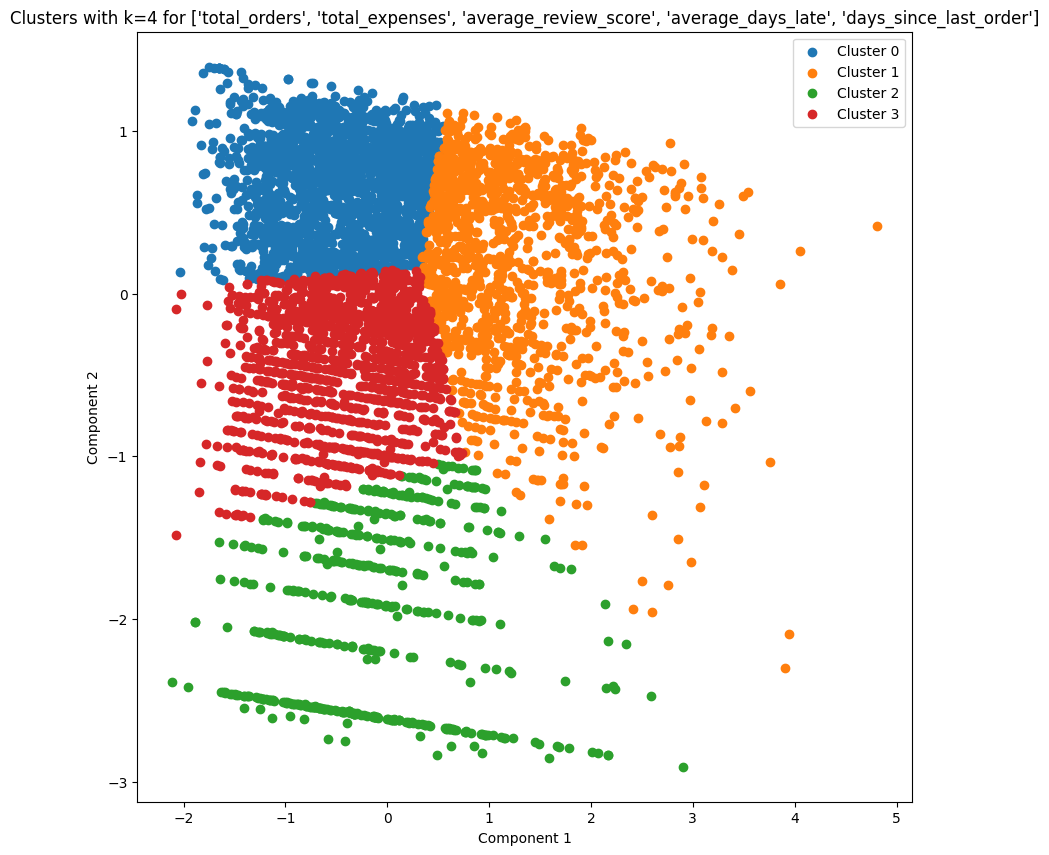

Appending ARI score 1.0 for period ending 2017-04-05 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-05-05 00:00:00 for 9590 orders.
Appending ARI score 0.390219597503406 for period ending 2017-05-05 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-06-05 00:00:00 for 13961 orders.
Appending ARI score 0.28764192061995547 for period ending 2017-06-05 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-07-05 00:00:00 for 17724 orders.
Appending ARI score 0.23611187093087446 for period ending 2017-07-05 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-08-05 00:00:00 for 22687 orders.
Appending ARI score 0.2462660890887582 for period ending 2017-08-05 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-09-05 00:00:00 for 27827 orders.
Appending ARI score 0.6436042863454124 for period ending 2017-09-05 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-10-05 00:00:00 for 32962 orders.
Appending ARI score 0.22708247075816915 for perio

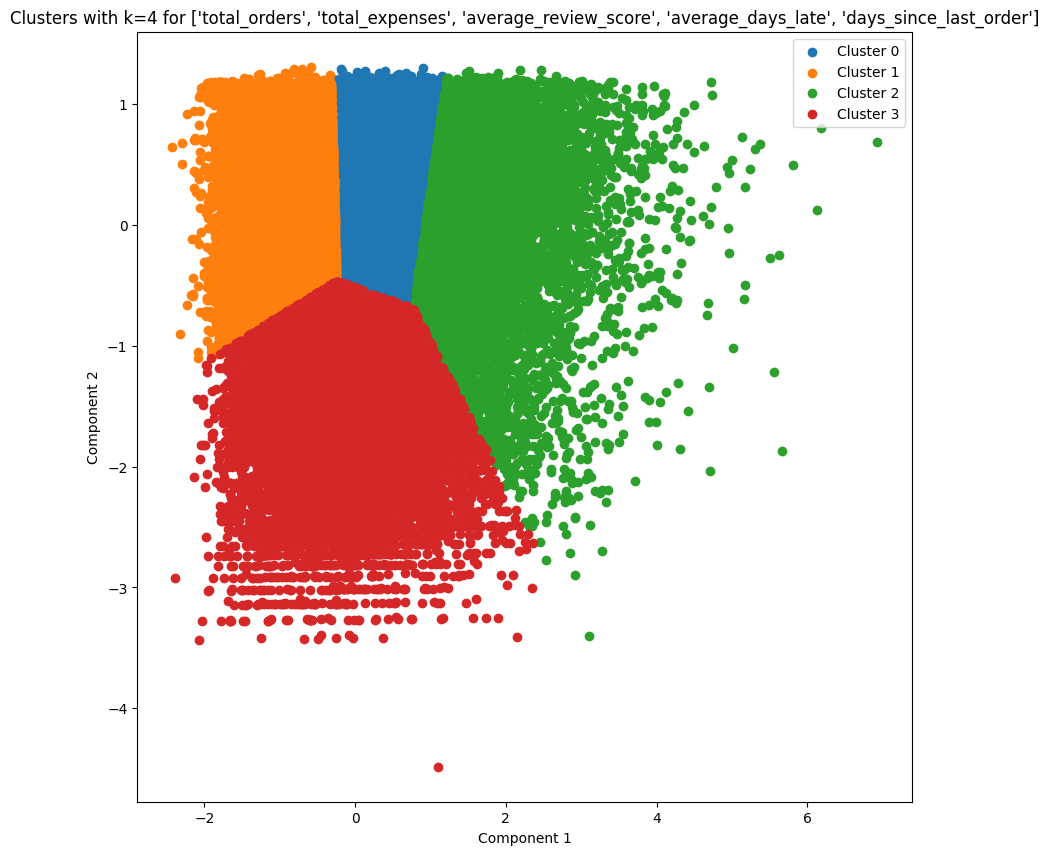

/var/folders/4f/ml64c07d1zsg_jvvydhyltjr0000gn/T/ipykernel_11092/2858917906.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


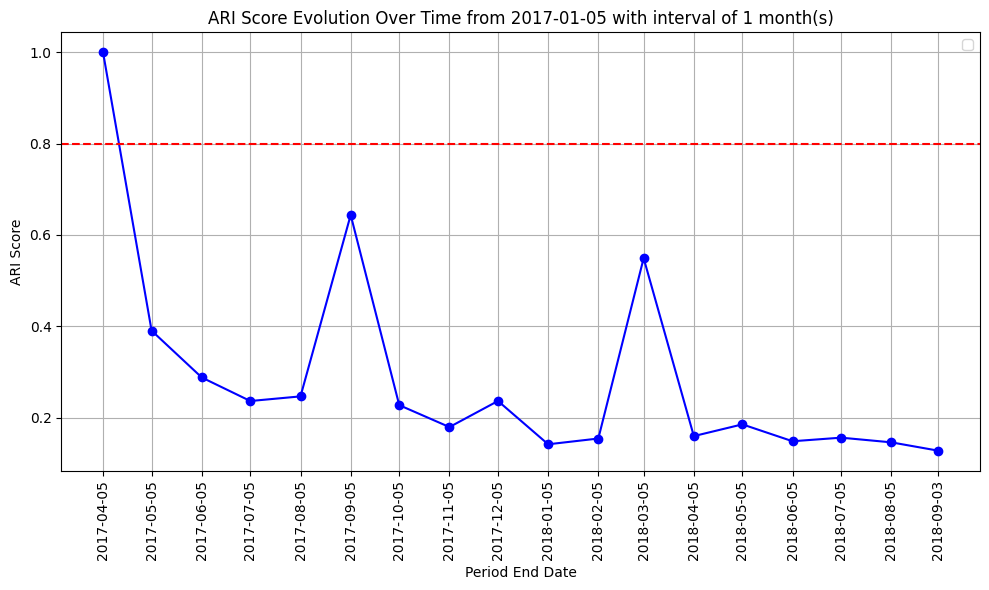

In [86]:
period = ["month", "month"]
f = [3, 1]
plot_ari_evolution(first_order_date, f, k, period)


Working on orders from 2017-01-05 00:00:00 to 2017-04-05 00:00:00 for 6612 orders.
Working on orders from 2017-01-05 00:00:00 to 2017-04-12 00:00:00 for 7229 orders.
Appending ARI score 0.41174163113016365 for period ending 2017-04-12 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-04-19 00:00:00 for 7742 orders.
Appending ARI score 0.2702981000502518 for period ending 2017-04-19 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-04-26 00:00:00 for 8576 orders.
Appending ARI score 0.8917342636732125 for period ending 2017-04-26 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-05-03 00:00:00 for 9339 orders.
Appending ARI score 0.3955698789588096 for period ending 2017-05-03 00:00:00
Working on orders from 2017-01-05 00:00:00 to 2017-05-10 00:00:00 for 10286 orders.
Working on orders from 2017-01-05 00:00:00 to 2017-05-17 00:00:00 for 11337 orders.
Appending ARI score 0.958464538995128 for period ending 2017-05-17 00:00:00
Working on orders from 2017-01-0

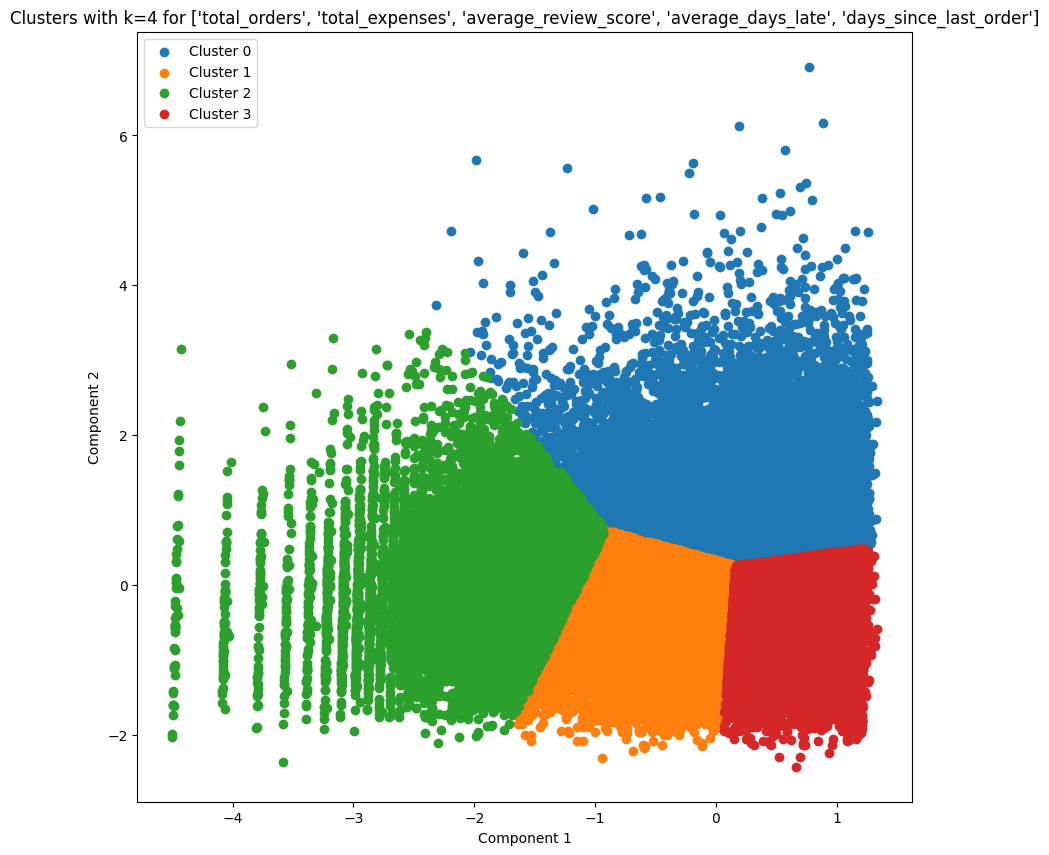

/var/folders/4f/ml64c07d1zsg_jvvydhyltjr0000gn/T/ipykernel_11092/3726858343.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


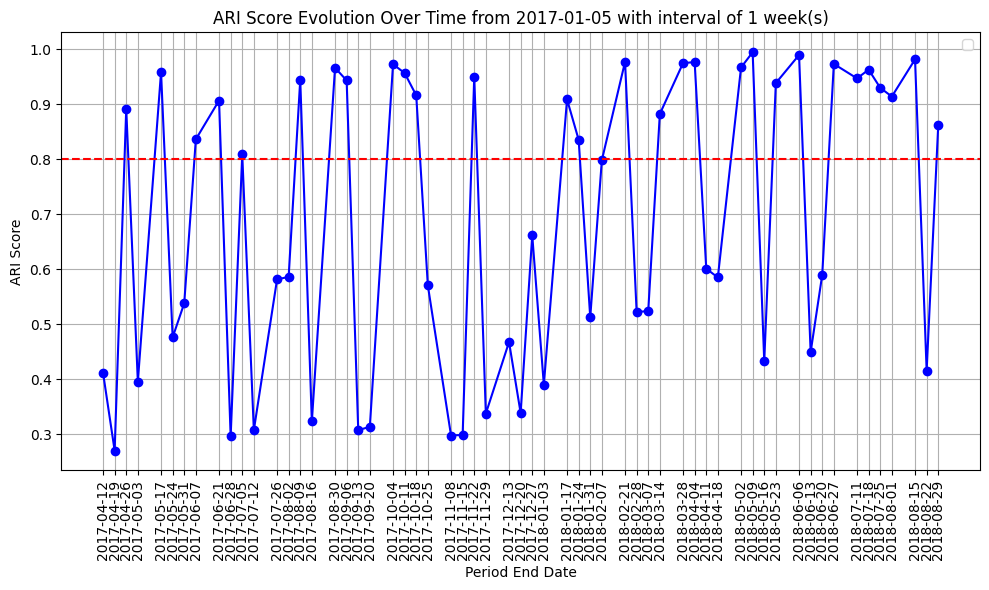

In [92]:
period = ["month", "week"]
f = [3, 1]
compare(first_order_date, f, k, period)
